In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import root

In [2]:
TFtot = 2000
kon = 0.0016399
koff = 0.34393
kbasal = 0.02612
kmax = 13.588
Kd = 956.75
n = 4.203
kdegR = 0.042116
ktrans = 1.4514
kdegP = 0.007

p =  kon, TFtot, koff, kbasal, kmax, n, Kd, kdegR, ktrans, kdegP

def khammash_ode(t,x,p,I):
    if callable(I):
        I = I(t)

    # Parameters
    kon, TFtot, koff, kbasal, kmax, n, Kd, kdegR, ktrans, kdegP = p

    kbasal_bar = kbasal / ((kbasal + kmax) / kdegR)
    kmax_bar = kmax / ((kbasal + kmax) / kdegR) #* (TFtot ** n)
    Kd_bar = Kd / TFtot
    ktrans_bar = ktrans * (kdegP/ktrans) # (kdegR/(kbasal+kmax))


    # Variables
    T, R, P = x
    T = np.max([0,T])
    # mRNA = mRNA * (kbasal + kmax) / kdegR

    dTdt = I * kon * (1 - T) - koff * T
    dRdt = kbasal_bar + kmax_bar * (T ** n) / ((Kd_bar ** n) + (T ** n)) - kdegR * R
    dProteindt = ktrans_bar * R - kdegP * P   

    return [dTdt, dRdt, dProteindt]

def fsolve_func(x,period,I,max_step):
    tspan = [0,period]
    sol = solve_ivp(khammash_ode, t_span=tspan, y0=x, args=(p,I),
                        rtol=1e-9, atol=1e-12, 
                        # t_eval=np.linspace(tspan[0], tspan[1], 1000000), 
                        method='BDF',
                        first_step = 0.0001,
                        max_step=max_step,
                        )
    # return (sol.y[:,:] - x[:])
    return (sol.y[:,-1] - x) * [1/10,10,1/10]

def I_fun_base(t, u, period, Imax):
    remainder = t - np.floor(t/period) * period
    I_out = np.zeros(np.array(t).size)
    I_out[remainder < u * period] = Imax
    return I_out

def steady_mRNA_solve(u, period, Imax, x_guess=None):

    I = lambda t: I_fun_base(t, u, period, Imax)

    if x_guess is None:
        x_guess = [u,u, u]

    if u > 0:
        max_step = u*period
    else:
        max_step = period / 10
    sol = root(fsolve_func, x_guess, args=(period,I,max_step), tol=1e-6)

    if not sol.success:
        print('failed')
        x_guess = [u,u, u]
        sol = root(fsolve_func, x_guess, args=(period,I,max_step), tol=1e-6)

    if not sol.success:
        print('it died :(')

    steady = np.maximum(sol.x,[0,0,0])

    return steady, sol.success, sol.message, sol.fun

def khammash_ode_simple(t,x,p,u, period, Imax):

    # Parameters
    kon, TFtot, koff, kbasal, kmax, n, Kd, kdegR, ktrans, kdegP = p

    x_guess = x
    global setpoint
    if setpoint is None:
        out, ier = steady_mRNA_solve(u, period, Imax, x_guess)
    else:
        out = setpoint
    # if ier != 1:
    #     out, ier = steady_mRNA_solve(u, period, Imax, x_guess=None)
    tau_TF = 1 / koff
    tau_mRNA = 1 / kdegR
    tau_Protein = 1 / kdegP

    # Variables
    TFon, mRNA, Protein = x
    TFon = np.max([0,TFon])
    # mRNA = mRNA * (kbasal + kmax) / kdegR

    dTFondt = (out[0] - TFon) / tau_TF
    dmRNAdt = (out[1] - mRNA) / tau_mRNA
    # dmRNAdt = dmRNAdt * kdegR / (kbasal + kmax) 
    dProteindt = (out[2] - Protein) / tau_Protein

    return [dTFondt, dmRNAdt, dProteindt]


steady fun out
[2.04129703e-13 8.75438414e-03 2.28096744e-01]
True
The solution converged.
[-1.57267310e-27 -4.60338365e-12 -5.00932629e-13]
The solver successfully reached the end of the integration interval.


(-0.05, 1.05)

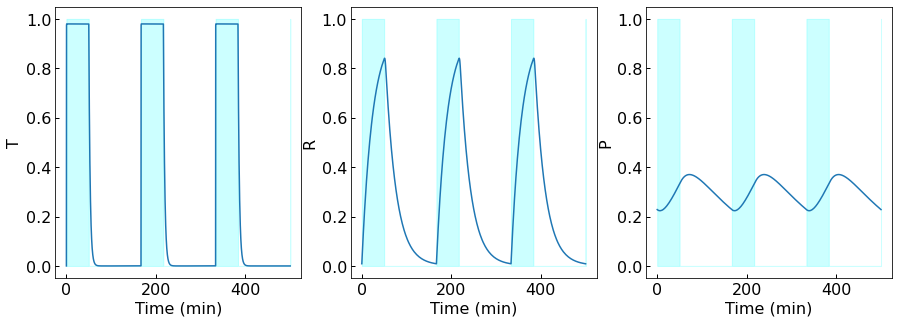

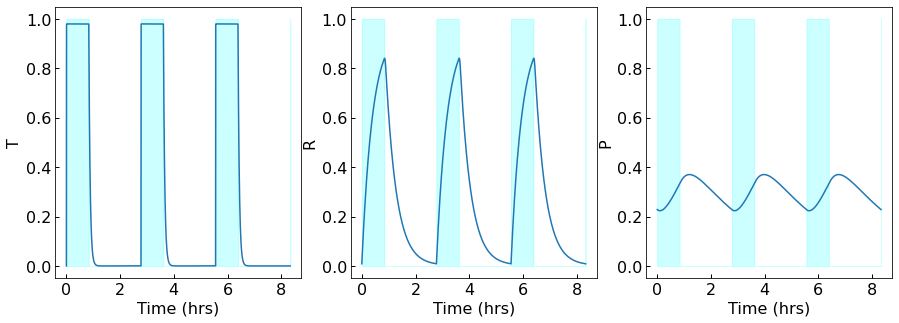

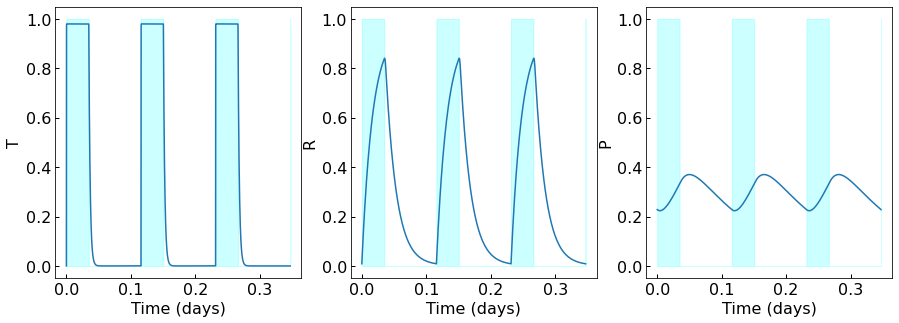

In [3]:
import matplotlib.pyplot as plt

u = 0.3
period = 10000 / 60
Imax = 10000

if u > 0:
    max_step = u*period
else:
    max_step = period / 10

out, ier, mesg, fun_val = steady_mRNA_solve(u, period, Imax)
print('steady fun out')
print(out)
print(ier)
print(mesg)
print(fun_val)
# out = sol.y[:,-1]

tspan = np.array([0, period*3])
I = lambda t: I_fun_base(t, u, period, Imax)
sol = solve_ivp(khammash_ode, t_span=tspan, y0=out, args=(p,I),
                    rtol=1e-6, atol=1e-9, 
                    # t_eval=np.linspace(tspan[0], tspan[1], 1000000), 
                    method='BDF',
                    first_step = 0.1,
                    max_step=max_step,
                    )

print(sol.message)

zero_line = np.zeros(sol.t.shape)

plt.figure(facecolor='white', figsize=(15,5))
ax = plt.subplot(131)
ax.plot(sol.t, sol.y[0])
ax.tick_params(labelsize=16, axis='both', direction='in', length=4, width=1)
ax.set_xlabel('Time (min)', fontsize=16)
ax.set_ylabel('T', fontsize=16)
ax.fill_between(sol.t, I(sol.t)/Imax, zero_line, color='cyan', alpha=0.2)
ax.set_ylim([-0.05,1.05])


# plt.figure(facecolor='white')
ax = plt.subplot(132)
ax.plot(sol.t, sol.y[1])
ax.tick_params(labelsize=16, axis='both', direction='in', length=4, width=1)
ax.set_xlabel('Time (min)', fontsize=16)
ax.set_ylabel('R', fontsize=16)
ax.fill_between(sol.t, I(sol.t)/Imax, zero_line, color='cyan', alpha=0.2)
ax.set_ylim([-0.05,1.05])

# plt.figure(facecolor='white')
ax = plt.subplot(133)
ax.plot(sol.t, sol.y[2])
ax.tick_params(labelsize=16, axis='both', direction='in', length=4, width=1)
ax.fill_between(sol.t, I(sol.t)/Imax, zero_line, color='cyan', alpha=0.2)
ax.set_xlabel('Time (min)', fontsize=16)
ax.set_ylabel('P', fontsize=16)
ax.set_ylim([-0.05,1.05])

plt.figure(facecolor='white', figsize=(15,5))
ax = plt.subplot(131)
ax.plot(sol.t/60, sol.y[0])
ax.tick_params(labelsize=16, axis='both', direction='in', length=4, width=1)
ax.set_xlabel('Time (hrs)', fontsize=16)
ax.set_ylabel('T', fontsize=16)
ax.fill_between(sol.t/60, I(sol.t)/Imax, zero_line, color='cyan', alpha=0.2)
ax.set_ylim([-0.05,1.05])


# plt.figure(facecolor='white')
ax = plt.subplot(132)
ax.plot(sol.t/60, sol.y[1])
ax.tick_params(labelsize=16, axis='both', direction='in', length=4, width=1)
ax.set_xlabel('Time (hrs)', fontsize=16)
ax.set_ylabel('R', fontsize=16)
ax.fill_between(sol.t/60, I(sol.t)/Imax, zero_line, color='cyan', alpha=0.2)
ax.set_ylim([-0.05,1.05])

# plt.figure(facecolor='white')
ax = plt.subplot(133)
ax.plot(sol.t/60, sol.y[2])
ax.tick_params(labelsize=16, axis='both', direction='in', length=4, width=1)
ax.fill_between(sol.t/60, I(sol.t)/Imax, zero_line, color='cyan', alpha=0.2)
ax.set_xlabel('Time (hrs)', fontsize=16)
ax.set_ylabel('P', fontsize=16)
ax.set_ylim([-0.05,1.05])

plt.figure(facecolor='white', figsize=(15,5))
ax = plt.subplot(131)
ax.plot(sol.t/60/24, sol.y[0])
ax.tick_params(labelsize=16, axis='both', direction='in', length=4, width=1)
ax.set_xlabel('Time (days)', fontsize=16)
ax.set_ylabel('T', fontsize=16)
ax.fill_between(sol.t/60/24, I(sol.t)/Imax, zero_line, color='cyan', alpha=0.2)
ax.set_ylim([-0.05,1.05])


# plt.figure(facecolor='white')
ax = plt.subplot(132)
ax.plot(sol.t/60/24, sol.y[1])
ax.tick_params(labelsize=16, axis='both', direction='in', length=4, width=1)
ax.set_xlabel('Time (days)', fontsize=16)
ax.set_ylabel('R', fontsize=16)
ax.fill_between(sol.t/60/24, I(sol.t)/Imax, zero_line, color='cyan', alpha=0.2)
ax.set_ylim([-0.05,1.05])

# plt.figure(facecolor='white')
ax = plt.subplot(133)
ax.plot(sol.t/60/24, sol.y[2])
ax.tick_params(labelsize=16, axis='both', direction='in', length=4, width=1)
ax.fill_between(sol.t/60/24, I(sol.t)/Imax, zero_line, color='cyan', alpha=0.2)
ax.set_xlabel('Time (days)', fontsize=16)
ax.set_ylabel('P', fontsize=16)
ax.set_ylim([-0.05,1.05])

In [5]:
from tqdm import tqdm

def steady_Protein_solve(u, period, Imax, x_guess=None):
    out, ier, mesg, fun_val = steady_mRNA_solve(u, period, Imax, x_guess)

    tspan = np.array([0, period])
    I = lambda t: I_fun_base(t, u, period, Imax)

    if u > 0:
        max_step = u*period
    else:
        max_step = period / 10

    sol = solve_ivp(khammash_ode, t_span=tspan, y0=out, args=(p,I),
                        rtol=1e-6, atol=1e-9, 
                        t_eval=np.linspace(tspan[0], tspan[1], 1000), 
                        method='BDF',
                        first_step = np.min((0.1, max_step/10)),
                        max_step=max_step,
                        )
                        
    return np.trapz(sol.y, sol.t, axis=1) / period, out #change to be mrna

u_arr = 10 ** np.linspace(-3, 0, 20)
period_arr = 10 ** np.linspace(1, 4, 20) / 60
# Imax = 10000
Imax_arr = 10 ** np.linspace(1, 4, 10)
Imax_arr = np.array([10000])

P_mean_mat = np.zeros((len(u_arr), len(period_arr), len(Imax_arr),3))

# P_mean_mat = np.zeros((len(u_arr), len(period_arr)))
x_guess = None

with tqdm(total=len(u_arr)*len(period_arr)* len(Imax_arr)) as pbar:
    for k, Imax in enumerate(Imax_arr):
        for i, u in enumerate(u_arr):
            for j, period in enumerate(period_arr):
                P_mean_mat[i, j, k,:], x_guess  = steady_Protein_solve(u, period, Imax, x_guess)
                # P_mean_mat[i, j], x_guess = steady_Protein_solve(u, period, Imax, x_guess)
                pbar.set_description('u = %.2e, period = %.2e, Imax = %.2e' % (u, period, Imax))
                pbar.update(1)


u = 1.00e-03, period = 5.60e+01, Imax = 1.00e+04:   4%|▍         | 17/400 [02:18<1:24:57, 13.31s/it]

failed


u = 1.44e-03, period = 3.89e+01, Imax = 1.00e+04:   9%|▉         | 36/400 [04:18<35:23,  5.83s/it]  

failed


u = 1.44e-03, period = 8.05e+01, Imax = 1.00e+04:  10%|▉         | 38/400 [04:46<1:01:02, 10.12s/it]

failed


u = 6.16e-03, period = 1.88e+01, Imax = 1.00e+04:  28%|██▊       | 114/400 [09:32<10:21,  2.17s/it] 

failed


u = 8.86e-03, period = 3.45e-01, Imax = 1.00e+04:  31%|███       | 123/400 [10:14<21:30,  4.66s/it]

failed


u = 2.64e-02, period = 8.05e+01, Imax = 1.00e+04:  50%|████▉     | 198/400 [13:45<09:13,  2.74s/it]

failed


u = 5.46e-02, period = 1.88e+01, Imax = 1.00e+04:  58%|█████▊    | 234/400 [15:15<05:16,  1.91s/it]

failed


u = 7.85e-02, period = 1.31e+01, Imax = 1.00e+04:  63%|██████▎   | 253/400 [15:56<03:27,  1.41s/it]

failed


u = 7.85e-02, period = 8.05e+01, Imax = 1.00e+04:  64%|██████▍   | 258/400 [16:27<12:17,  5.19s/it]

failed


u = 1.62e-01, period = 1.67e+02, Imax = 1.00e+04:  75%|███████▌  | 300/400 [19:00<05:42,  3.43s/it]

failed


u = 2.34e-01, period = 5.60e+01, Imax = 1.00e+04:  79%|███████▉  | 317/400 [19:30<04:07,  2.98s/it]

failed


u = 3.36e-01, period = 1.67e+02, Imax = 1.00e+04:  85%|████████▌ | 340/400 [20:47<06:35,  6.59s/it]

failed


u = 4.83e-01, period = 1.16e+02, Imax = 1.00e+04:  90%|████████▉ | 359/400 [21:29<02:15,  3.30s/it]

failed


u = 1.00e+00, period = 1.67e+02, Imax = 1.00e+04: 100%|██████████| 400/400 [22:21<00:00,  3.35s/it]


(20, 20)
(20, 20)
(20, 20)


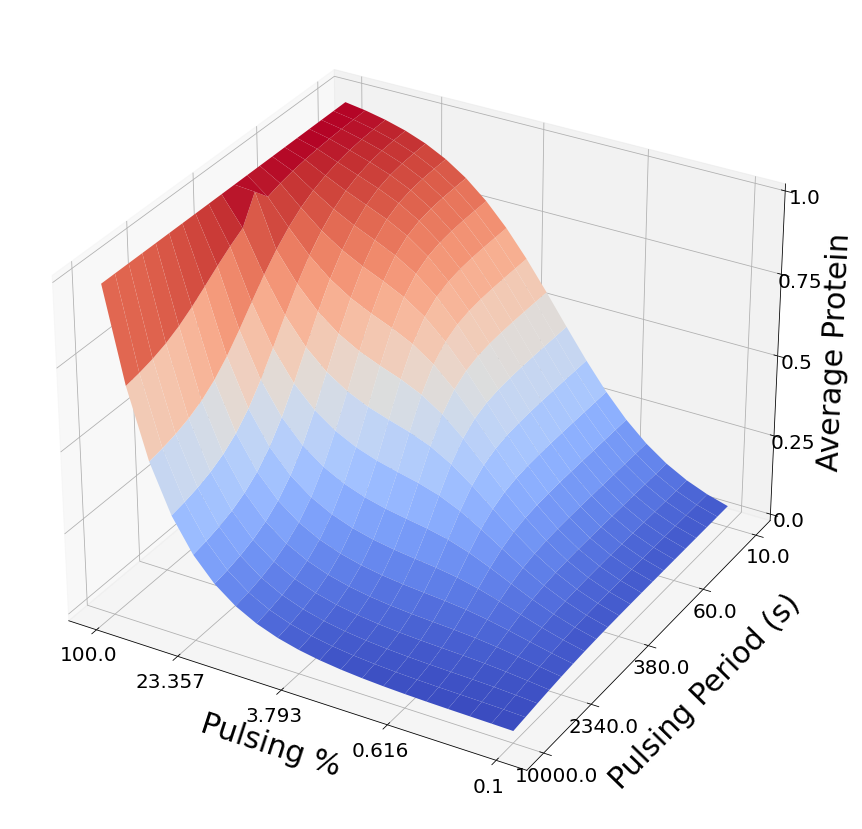

In [7]:
from matplotlib import cm

# ave_trans = np.zeros((len(pulse_perc), len(pulse_period)))

X, Y = np.meshgrid(u_arr, period_arr)
Z = P_mean_mat[...,0,0].T

print(X.shape)
print(Y.shape)
print(Z.shape)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(30,15), facecolor='white')
surf = ax.plot_surface(np.log10(X), np.log10(Y), Z, cmap=cm.coolwarm,
                       linewidth=0)
ax.set_xlabel('\nPulsing %', fontsize=30)
ax.set_ylabel('\n\nPulsing Period (s)', fontsize=30)
ax.set_zlabel('\nAverage Protein', fontsize=30)

ax.set_xticks(np.log10(u_arr)[[0,5,10,15,-1]])
ax.set_xticklabels(labels=(u_arr*100).round(3)[[0,5,10,15,-1]], fontsize=20)
ax.set_yticks(np.log10(period_arr)[[0,5,10,15,-1]])
ax.set_yticklabels(labels=(period_arr*60).round(-1)[[0,5,10,15,-1]], fontsize=20)
ax.set_zticks(np.linspace(0, 1, 5))
ax.set_zticklabels(labels=(np.linspace(0, 1, 5)).round(2), fontsize=20)

ax.view_init(30, 120)
# ax.yaxis.set_scale('log')

# print(pulse_perc)



In [8]:
print(u_arr)

[0.001      0.00143845 0.00206914 0.00297635 0.00428133 0.00615848
 0.00885867 0.01274275 0.01832981 0.02636651 0.0379269  0.05455595
 0.078476   0.11288379 0.16237767 0.23357215 0.33598183 0.48329302
 0.6951928  1.        ]


In [85]:
from scipy.optimize import minimize


def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def predfun(xcoord, m, n):
    return (xcoord *m +n)

def truefun(x):
    return (x)

def fminfun(x):
    a,b,c, m, n = x
    error = 0
    for k, Imax in enumerate(Imax_arr):
        for i, u in enumerate(u_arr):
            for j, period in enumerate(period_arr):
                # kbasal_bar = kbasal / ((kbasal + kmax) / kdegR)
                # kmax_bar = kmax / ((kbasal + kmax) / kdegR) #* (TFtot ** n)
                # Kd_bar = Kd / TFtot
                # ktrans_bar = ktrans * (kdegP/ktrans) # (kdegR/(kbasal+kmax))
                # xcoord = ((Imax * kon) / koff) ** a * \
                #         (kdegR * period) ** b * \
                #             u ** c

                xcoord = ((Imax * kon) ** 2) / (period * koff * ((koff + Imax * kon) **2)) * (u ** a) #* np.log(u ** b)# * np.exp(u ** c)

                true = truefun(P_mean_mat[i, j, k,1])
                pred = predfun(xcoord, m, n)
                error += ((pred - true)/true) ** 2
                # P_mean_mat
    return np.sqrt(error)

x0 = [0, 1.13, 1.13, 1.13, 1.13]
# print(fminfun(x0))

print('===================')

res = minimize(fminfun, x0, tol=1e-6,method='BFGS', )

print(res.x)
print(fminfun(res.x))
print(res.fun)
print(res.success)
print(res.message)

[1.13492936 1.13       1.13       0.15461296 0.00254934]
17.541133549703382
17.541133549703382
False
Desired error not necessarily achieved due to precision loss.


myk
0


/tmp/ipykernel_4995/611834216.py:47: RuntimeWarning: divide by zero encountered in log
  plt.scatter(np.log(xcoord_arr), (P_mean_mat[...,0]), s=100, c=np.log(cmap_arr))


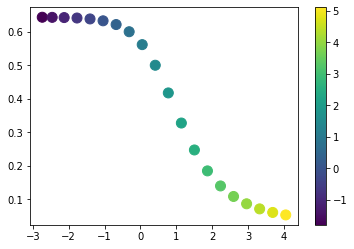

In [136]:
a,b,c, m, n = res.x
import scipy

plt.figure(facecolor='white')
xmin = 1e9
xmax = -1e9

xcoord_arr = np.zeros(P_mean_mat.shape[:-1])
cmap_arr = np.zeros(P_mean_mat.shape[:-1])

for k, Imax in enumerate(Imax_arr):
    print('myk')
    print(k)
    # i = 0
    for i, u in enumerate(u_arr):
        i=10
        for j, period in enumerate(period_arr):
            # xcoord = ((Imax * kon) / koff) ** a * \
            #         (kdegR * period) ** b * \
            #             u ** c

            # xcoord = ((Imax * kon) ** 2) / (period * koff * ((koff + Imax * kon) **2))

            beta = koff * period
            alpha = Imax * kon / koff

            # xcoord = ((Imax * kon) ** 2) / (period * koff * ((koff + Imax * kon) **2)) * u ** 1
            # xcoord = period
            xcoord = (alpha**2)/((1+alpha)**4 + (beta)**2)
            # xcoord = (alpha**2)/((1+alpha)**3)
            xcoord = beta / np.tanh(0.5*(1+alpha)*beta)

            xcoord_arr[i, j, k] = xcoord
            cmap_arr[i, j, k] = period

            if xcoord < xmin:
                xmin = xcoord
            if xcoord > xmax:
                xmax = xcoord
            pred = predfun(xcoord, m, n)
            true = truefun(P_mean_mat[i, j, k,1])
            # plt.scatter(xcoord, np.arctanh(P_mean_mat[i, j, k]), s=100, c='k', alpha=0.1)

            # plt.scatter(true, pred, s=100, c='k')
            # print(u)

plt.scatter(np.log(xcoord_arr), (P_mean_mat[...,0]), s=100, c=np.log(cmap_arr))
plt.colorbar()
            
# plt.plot([0, 1], [0, 1], 'k--')
# plt.yscale("log")
# plt.xscale("log")
# plt.plot([xmin, xmax],[xmin*m+n, xmax*m+n], 'k--')